In [2]:
import numpy as np 
import pandas as pd 
import json
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras

import keras_tuner

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score

from datetime import datetime
import os

def save_json(filename, variable):
    with open(filename, 'w') as json_file:
        json.dump(variable, json_file, indent=4)
        
def open_json(filename):
    with open(filename, 'r') as json_file:
        return json.load(json_file)

def now():
    print(datetime.now())
    
#-----------------------PARAMS
input_shape = (128, 128, 3)
image_size = np.asarray(input_shape)[:2]
training_dir = '/kaggle/input/muffin-vs-chihuahua-image-classification/train'
testing_dir = '/kaggle/input/muffin-vs-chihuahua-image-classification/test'
plots_dir = "imgs"
test_set_perc = 0.20          #test set = 20% of training set
reduced_dataset_perc = 0.50   #reduced = 50% of the dataset
batch_size = 32
n_splits = 5                  # number of folds for k-fold cross validation
#-----------------------------

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# models definition

model_mlp = models.Sequential([
    Input(shape=input_shape),
    layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation='relu'),
    
    layers.Dense(1, activation='sigmoid')
])

model_cnn = models.Sequential([
    Input(shape=input_shape),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3), activation='relu'),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_cnn_1 = models.Sequential([
    Input(shape=input_shape),
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

models_list = [model_mlp, model_cnn, model_cnn_1]
model_names = ["mlp", "cnn", "cnn1"]
models_json = {}

@tf.keras.utils.register_keras_serializable()
def zero_one_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.square(tf.round(y_pred) - y_true))

for cont, i in enumerate(models_list):
    i.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = ['binary_accuracy', zero_one_loss]
    )
    models_json[model_names[cont]] = i.to_json()
    
now()

2024-05-31 15:06:28.883123


# Dataset preparation

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
  Conversion...


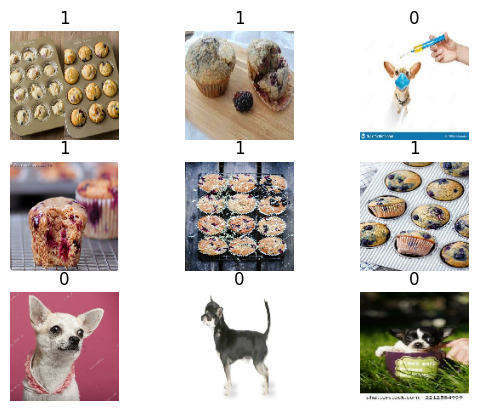

(4734, 4734, 1183, 1183)
2024-05-31 15:07:51.389435


In [3]:
ds_train = image_dataset_from_directory(
    training_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=None,
    shuffle=True,
    color_mode='rgb'
)
ds_test = image_dataset_from_directory(
    testing_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=None,
    shuffle=True,
    color_mode='rgb'
)

def normalize_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

#dynamically adjust the value of the buffer size based on available CPU. This allows TensorFlow to choose the optimal amount of parallelism to use when reading data from disk
AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (
    ds_train
    .map(normalize_image)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test = (
    ds_test
    .map(normalize_image)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

dataset = ds_train.concatenate(ds_test)

print("  Conversion...")
X = np.array(list(dataset.map(lambda X, y: X).as_numpy_iterator()))
y = np.array(list(dataset.map(lambda X, y: y).as_numpy_iterator()))

test_size = int(len(X) * test_set_perc)
train_size = len(X) - test_size

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X[i])
    plt.title(int(y[i][0]))
    plt.axis("off")
    
plt.savefig(f"{plots_dir}/dataset_sample.png")
plt.show()

print((
    len(X_train),
    len(y_train),
    len(X_test),
    len(y_test)
))

now()

In [5]:
def train_models(models_list, X_train, y_train, X_test, y_test, num_epochs = 50, verbosity = 1, name="", show_plots = True):
    evaluations = []
    histories = []
    
    for i, model in enumerate(models_list):
        history = model.fit(
                X_train, 
                y_train, 
                validation_data = (X_test, y_test),
                epochs = num_epochs, 
                verbose = verbosity,
                batch_size = batch_size,
                shuffle='batch',
                callbacks = callbacks.EarlyStopping(
                        monitor='val_loss', 
                        patience=10, 
                        restore_best_weights=True
                    )
            )

        evaluation = model.evaluate(X_test, y_test, return_dict=True)
        evaluations.append(evaluation)
        histories.append(history.history)
        
        if(show_plots):
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
            history_frame = pd.DataFrame(history.history)
            history_frame.loc[:, ['loss', 'val_loss']].plot(title='Losses', ax=axes[0])
            history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Binary accuracy", ax=axes[1])
            history_frame.loc[:, ['zero_one_loss', 'val_zero_one_loss']].plot(title="zero-one loss", ax=axes[2])
            plt.tight_layout(pad=2.0)

            plt.savefig(f"{plots_dir}/{model_names[i]}_{name}.png")
            plt.show()
        
    return evaluations, histories

## First training

-> Model mlp
2024-05-31 15:08:52.355435
Epoch 1/50
 24/148 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.5206 - loss: 6.2905 - zero_one_loss: 0.4794

I0000 00:00:1717168139.326893     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - binary_accuracy: 0.5072 - loss: 3.1582 - zero_one_loss: 0.4928 - val_binary_accuracy: 0.5799 - val_loss: 0.6713 - val_zero_one_loss: 0.4202
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.5659 - loss: 0.7247 - zero_one_loss: 0.4341 - val_binary_accuracy: 0.6957 - val_loss: 0.6092 - val_zero_one_loss: 0.3044
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.6374 - loss: 0.6517 - zero_one_loss: 0.3626 - val_binary_accuracy: 0.6872 - val_loss: 0.5910 - val_zero_one_loss: 0.3127
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.6670 - loss: 0.6114 - zero_one_loss: 0.3330 - val_binary_accuracy: 0.6813 - val_loss: 0.6053 - val_zero_one_loss: 0.3187
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7000 - loss: 0.5876 - zero_one_loss: 0.3000 - val_binary_accuracy: 0.7439 - val_loss: 0.5540 - val_zero_one_loss: 0.2562
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━

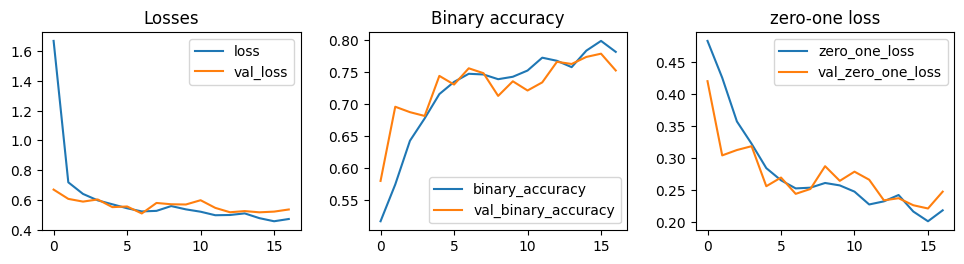

2024-05-31 15:09:26.955207

-> Model cnn
2024-05-31 15:09:27.034729
Epoch 1/50


2024-05-31 15:09:30.787000: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31758: 7.18885, expected 6.34915
2024-05-31 15:09:30.787071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31794: 6.79032, expected 5.95062
2024-05-31 15:09:30.787087: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31795: 6.91364, expected 6.07395
2024-05-31 15:09:30.787113: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31796: 7.21123, expected 6.37153
2024-05-31 15:09:30.787129: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31809: 7.14567, expected 6.30597
2024-05-31 15:09:30.787141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31823: 7.30269, expected 6.46299
2024-05-31 15:09:30.787154: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31824: 7.17199, expected 6.33229
2024-05-31 15:09:30.787162:

146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.5965 - loss: 3.0136 - zero_one_loss: 0.4035

2024-05-31 15:09:35.262844: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47631: 7.35615, expected 6.48968
2024-05-31 15:09:35.262913: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47632: 6.655, expected 5.78852
2024-05-31 15:09:35.262928: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47633: 7.19442, expected 6.32794
2024-05-31 15:09:35.262941: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47634: 7.37407, expected 6.50759
2024-05-31 15:09:35.262959: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47635: 6.61442, expected 5.74795
2024-05-31 15:09:35.262971: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47636: 6.43599, expected 5.56952
2024-05-31 15:09:35.262982: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47637: 7.15546, expected 6.28899
2024-05-31 15:09:35.262993: E

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.5977 - loss: 2.9890 - zero_one_loss: 0.4023

2024-05-31 15:09:39.012914: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47806: 4.985, expected 4.36518
2024-05-31 15:09:39.012982: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48084: 4.83614, expected 4.21633
2024-05-31 15:09:39.012992: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48178: 5.10975, expected 4.48993
2024-05-31 15:09:39.013000: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48219: 4.42858, expected 3.80877
2024-05-31 15:09:39.013009: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48335: 5.1248, expected 4.50498
2024-05-31 15:09:39.013017: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48451: 5.02718, expected 4.40737
2024-05-31 15:09:39.013026: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48815: 5.13136, expected 4.51155
2024-05-31 15:09:39.013034: E 

148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - binary_accuracy: 0.5983 - loss: 2.9769 - zero_one_loss: 0.4017 - val_binary_accuracy: 0.8183 - val_loss: 0.4270 - val_zero_one_loss: 0.1818
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.7985 - loss: 0.4441 - zero_one_loss: 0.2015 - val_binary_accuracy: 0.8284 - val_loss: 0.4007 - val_zero_one_loss: 0.1717
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8334 - loss: 0.3862 - zero_one_loss: 0.1666 - val_binary_accuracy: 0.8318 - val_loss: 0.3872 - val_zero_one_loss: 0.1683
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8284 - loss: 0.3783 - zero_one_loss: 0.1716 - val_binary_accuracy: 0.8563 - val_loss: 0.3650 - val_zero_one_loss: 0.1438
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8543 - loss: 0.3302 - zero_one_loss: 0.1457 - val_binary_accuracy: 0.8597 - val_loss: 0.3529 - val_zero_one_loss: 0.1404
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━

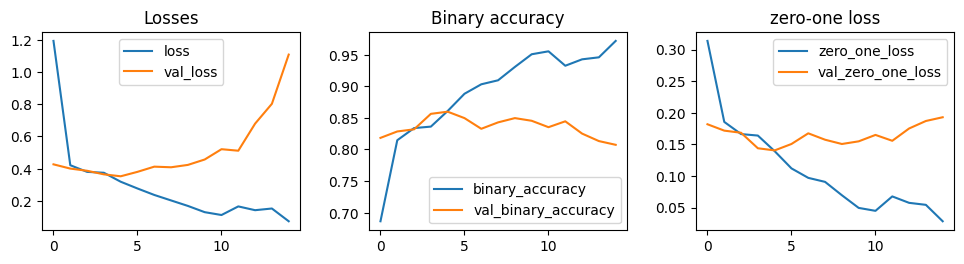

2024-05-31 15:10:08.226662

-> Model cnn1
2024-05-31 15:10:08.377032
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - binary_accuracy: 0.6000 - loss: 0.6484 - zero_one_loss: 0.4000 - val_binary_accuracy: 0.7405 - val_loss: 0.5228 - val_zero_one_loss: 0.2595
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7769 - loss: 0.4719 - zero_one_loss: 0.2231 - val_binary_accuracy: 0.7912 - val_loss: 0.4372 - val_zero_one_loss: 0.2089
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8331 - loss: 0.3892 - zero_one_loss: 0.1669 - val_binary_accuracy: 0.8538 - val_loss: 0.3530 - val_zero_one_loss: 0.1463
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8499 - loss: 0.3458 - zero_one_loss: 0.1501 - val_binary_accuracy: 0.8715 - val_loss: 0.3118 - val_zero_one_loss: 0.1285
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8598 - loss: 0.3291 - zero_one_loss: 0.1402 - val_binary_accuracy: 0.8639 - val_

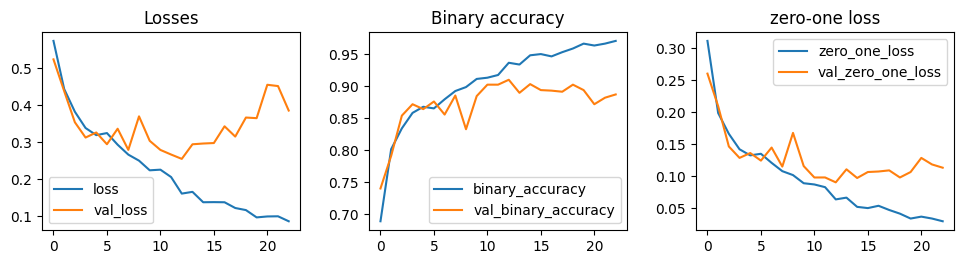

2024-05-31 15:10:55.747205



In [6]:
evaluations = {}
histories = {}
for k in models_json.keys():
    print(f"-> Model {k}")
    model = models.model_from_json(models_json[k])
    now()
    evaluation, history = train_models([model], X_train, y_train, X_test, y_test, name=f"first_training-{k}")
    evaluations[k] = evaluation
    histories[k] = history
    now()
    print()


In [7]:
for k in models_json.keys():
    print(f"{k}: ",json.dumps(evaluations[k], indent=1), "\n")

mlp:  [
 {
  "binary_accuracy": 0.7557058334350586,
  "loss": 0.5115615725517273,
  "zero_one_loss": 0.24433302879333496
 }
] 

cnn:  [
 {
  "binary_accuracy": 0.8596788048744202,
  "loss": 0.3529481589794159,
  "zero_one_loss": 0.14039340615272522
 }
] 

cnn1:  [
 {
  "binary_accuracy": 0.9095519781112671,
  "loss": 0.2541773021221161,
  "zero_one_loss": 0.09050785005092621
 }
] 



## Data augmentation

starting conversion...


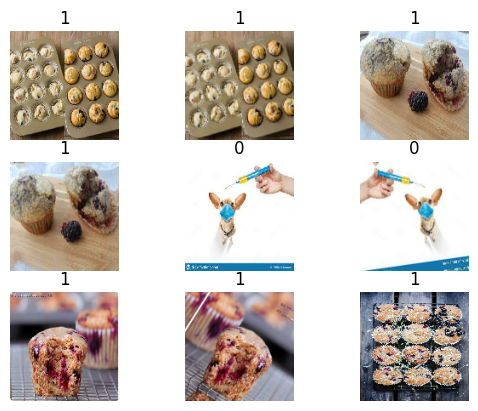

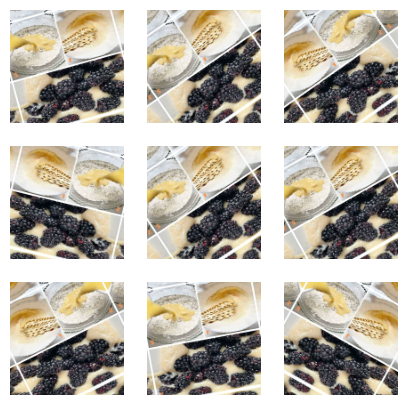

2024-05-31 15:11:56.173560


In [8]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

input_images = keras.Input(shape=image_size)

augmented_images = data_augmentation(X)


print("starting conversion...")
X_augm = np.zeros((len(X)*2, input_shape[0], input_shape[1], input_shape[2]))
y_augm = np.zeros((len(y)*2, 1))

index_norm = 0
index_augm = 0
for i in range(len(X)*2):
    if(i%2==0):
        X_augm[i] = X[index_norm]
        y_augm[i][0] = y[index_norm][0]
        index_norm += 1
    else:
        X_augm[i] = augmented_images[index_augm]
        y_augm[i][0] = y[index_augm][0]
        index_augm += 1


test_augm_size = int(len(X)*test_set_perc)
train_augm_size = len(X) - test_size

X_augm_train = X_augm[:train_augm_size]
y_augm_train = y_augm[:train_augm_size]

X_augm_test = X_augm[train_augm_size:]
y_augm_test = y_augm[train_augm_size:] 


for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_augm[i])
    plt.title(int(y_augm[i][0]))
    plt.axis("off")
plt.show()

plt.figure(figsize=(5, 5))

for i in range(9):
    image = data_augmentation(X[100])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(image))
    plt.axis("off")

plt.show()

now()

---

## Training after augmentation

-> Model mlp
2024-05-30 08:39:12.151284
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - binary_accuracy: 0.5172 - loss: 3.5084 - zero_one_loss: 0.4828 - val_binary_accuracy: 0.4937 - val_loss: 0.6866 - val_zero_one_loss: 0.5064
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.5597 - loss: 0.7171 - zero_one_loss: 0.4403 - val_binary_accuracy: 0.4962 - val_loss: 0.6951 - val_zero_one_loss: 0.5038
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.5874 - loss: 0.6992 - zero_one_loss: 0.4126 - val_binary_accuracy: 0.7067 - val_loss: 0.5847 - val_zero_one_loss: 0.2933
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.6312 - loss: 0.6424 - zero_one_loss: 0.3688 - val_binary_accuracy: 0.4776 - val_loss: 0.6796 - val_zero_one_loss: 0.5225
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.5324 - loss: 0.6710 - zero_one_loss: 0.4676 - val_binary_accuracy: 0.5410 - val_loss: 0.6896 - val_zero_one_l

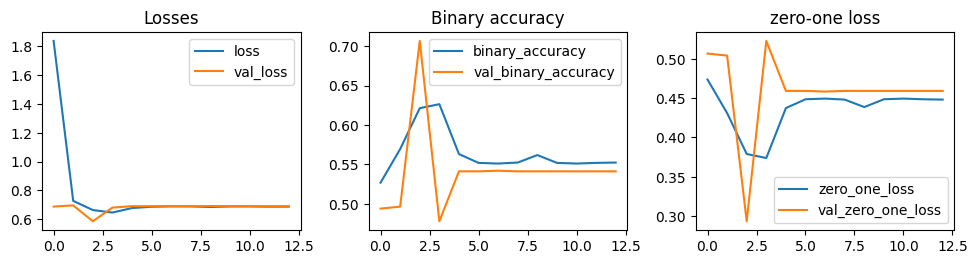

2024-05-30 08:39:41.106698

-> Model cnn
2024-05-30 08:39:41.165090
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - binary_accuracy: 0.5884 - loss: 2.7732 - zero_one_loss: 0.4116 - val_binary_accuracy: 0.7523 - val_loss: 0.5690 - val_zero_one_loss: 0.2477
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.7012 - loss: 0.7404 - zero_one_loss: 0.2988 - val_binary_accuracy: 0.7819 - val_loss: 0.4761 - val_zero_one_loss: 0.2180
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.7908 - loss: 0.4675 - zero_one_loss: 0.2092 - val_binary_accuracy: 0.8073 - val_loss: 0.4397 - val_zero_one_loss: 0.1927
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8045 - loss: 0.4273 - zero_one_loss: 0.1955 - val_binary_accuracy: 0.8360 - val_loss: 0.3949 - val_zero_one_loss: 0.1640
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.8252 - loss: 0.4130 - zero_one_loss: 0.1748 - val_binary_accuracy: 0.8343 - va

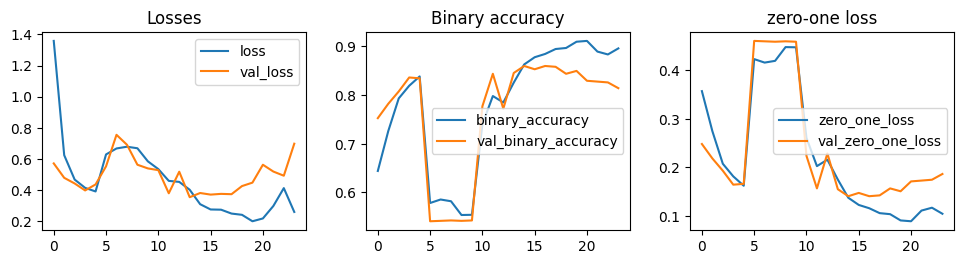

2024-05-30 08:40:34.113685

-> Model cnn1
2024-05-30 08:40:34.233016
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - binary_accuracy: 0.6014 - loss: 0.6459 - zero_one_loss: 0.3986 - val_binary_accuracy: 0.7084 - val_loss: 0.5418 - val_zero_one_loss: 0.2917
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7967 - loss: 0.4756 - zero_one_loss: 0.2033 - val_binary_accuracy: 0.7117 - val_loss: 0.5315 - val_zero_one_loss: 0.2883
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8112 - loss: 0.4463 - zero_one_loss: 0.1888 - val_binary_accuracy: 0.7312 - val_loss: 0.5021 - val_zero_one_loss: 0.2688
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8233 - loss: 0.4120 - zero_one_loss: 0.1767 - val_binary_accuracy: 0.7684 - val_loss: 0.4547 - val_zero_one_loss: 0.2316
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8415 - loss: 0.3781 - zero_one_loss: 0.1585 - val_binary_accuracy: 0.8081 - val_

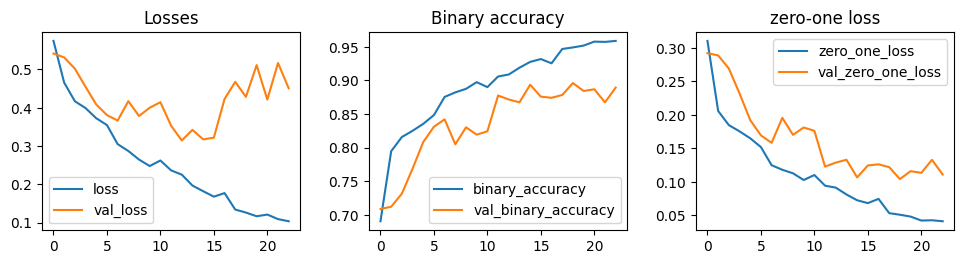

2024-05-30 08:41:20.007572



In [7]:
current_models_list = []
evaluations = {}
histories = {}
for k in models_json.keys():
    print(f"-> Model {k}")
    model = models.model_from_json(models_json[k])
    now()
    evaluation, history = train_models([model], X_augm_train, y_augm_train, X_test, y_test, name="augm")
    evaluations[k] = evaluation
    histories[k] = history
    now()

### Evaluations

In [8]:
for k in models_json.keys():
    print(f"{k}: ",json.dumps(evaluations[k], indent=1), "\n")

mlp:  [
 {
  "binary_accuracy": 0.7066779136657715,
  "loss": 0.584687352180481,
  "zero_one_loss": 0.29326504468917847
 }
] 

cnn:  [
 {
  "binary_accuracy": 0.8453085422515869,
  "loss": 0.3512997329235077,
  "zero_one_loss": 0.15464253723621368
 }
] 

cnn1:  [
 {
  "binary_accuracy": 0.8715131282806396,
  "loss": 0.3144361674785614,
  "zero_one_loss": 0.12859633564949036
 }
] 



# Hyperparameter tuning

### Models definition

In [9]:
def build_model_mlp(hp):
    dropouts = hp.Float("dropout", min_value = 0.2, max_value = 0.5, step = 0.1)
    
    model = models.Sequential([
        
        Input(shape=input_shape),
        layers.Flatten(),
        
        layers.Dense(256, activation='relu'),
        
        layers.Dense(hp.Int("dense_1", min_value=int(image_size[0]/2), max_value=256, step=32), activation='relu'),
        layers.Dropout(dropouts),
        
        layers.Dense(hp.Int("dense_2", min_value=int(image_size[0]/4), max_value= 256, step=32), activation='relu'),
        layers.Dropout(dropouts),
        
        layers.Dense(hp.Int("dense_3", min_value=int(image_size[0]/6), max_value= 256, step=32), activation='relu'),
        
        layers.Dense(1, activation='sigmoid')
    ])
        
    model.compile(
        optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
        loss = 'binary_crossentropy',
        metrics = ['binary_accuracy', 'accuracy', zero_one_loss]
    )
    
    return model

def build_model_cnn(hp):
    dropouts = hp.Float("dropout", min_value = 0.2, max_value = 0.5, step = 0.1)
    
    model = models.Sequential([
        Input(shape=input_shape),

        layers.Conv2D(hp.Choice("conv 1", [32, 64]), (3,3), activation='relu'),
        layers.MaxPooling2D((3,3)),

        layers.Conv2D(hp.Choice("conv 3", [32, 64]),(3,3), activation='relu'),

        layers.Flatten(),
        layers.Dense(hp.Choice("dense", [32, 64, 128]), activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
        loss = 'binary_crossentropy',
        metrics = ['binary_accuracy', 'accuracy', zero_one_loss]
    )
    
    return model


def build_model_cnn1(hp):    
    dropouts = hp.Float("dropout", min_value = 0.2, max_value = 0.5, step = 0.1)
                                                    
    model = models.Sequential([
        Input(shape=input_shape),

        layers.Conv2D(
            filters = hp.Int('conv_1_filter', min_value=32, max_value=128, step=32), 
            kernel_size = hp.Choice('conv_2_kernel', values = [3,5]),
            activation = 'relu'
        ),
        layers.Dropout(dropouts),

        layers.Conv2D(
            filters = hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
            kernel_size = hp.Choice('conv_2_kernel', values = [3,5]),
            activation = 'relu'
        ),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(dropouts),
        
        layers.Conv2D(
            filters = hp.Int('conv_3_filter', min_value=16, max_value=64, step=16),
            kernel_size = hp.Choice('conv_2_kernel', values = [3,5]),
            activation = 'relu'
        ),
        layers.Dropout(dropouts),

        layers.Flatten(),
        layers.Dense(
            units = hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
            activation = 'relu'
        ),
        layers.Dense(
            units = hp.Int('dense_2_units', min_value=16, max_value=32, step=16),
            activation = 'relu'
        ),
        
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
        loss = 'binary_crossentropy',
        metrics = ['binary_accuracy', 'accuracy', zero_one_loss]
    )
    
    return model

hyper_models = {
    "mlp": build_model_mlp,
    "cnn": build_model_cnn,
    "cnn1":build_model_cnn1
}

tuned_models_json = {}

now()

2024-05-31 15:12:55.663825


### Hyperparameter Search

In [12]:
# tuning on a subset of the dataset
reduced_X_train_size = int(len(X) * reduced_dataset_perc)
reduced_X_test_size = int(len(X_train) * reduced_dataset_perc)

reduced_X_train = X[:reduced_X_train_size]
reduced_y_train = y[:reduced_X_train_size]
reduced_X_test = X_test[:reduced_X_test_size]
reduced_y_test = y_test[:reduced_X_test_size]

(
len(reduced_y_test),
len(reduced_X_train),
len(X)
)

(1183, 2958, 5917)

In [ ]:
def tune(model_name, model_builder):
    tuner = keras_tuner.RandomSearch(
        model_builder,
        project_name = f"project {model_name}",
        objective='val_accuracy',
        distribution_strategy=tf.distribute.MirroredStrategy(),
        max_trials=50,
        overwrite = True
        )

    tuner.search(reduced_X_train, reduced_y_train, epochs=20, validation_data=(reduced_X_test, reduced_y_test))
    return tuner
    
def get_best_model(tuner): 
    best_hyperparams = tuner.get_best_hyperparameters(num_trials = 1)[0]
    best_model = tuner.hypermodel.build(best_hyperparams)
    return best_model

#### MLP

In [ ]:
tuner = tune('mlp', hyper_models['mlp'])
best_mlp = get_best_model(tuner)
best_mlp.summary()
tuned_models_json['cmlp'] = best_mlp.to_json()
best_hyperparams = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hyperparams.values

#### CNN

In [ ]:
tuner = tune('cnn', hyper_models['cnn'])
best_cnn = get_best_model(tuner)
best_cnn.summary()
tuned_models_json['cnn'] = best_cnn.to_json()
best_hyperparams = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hyperparams.values

#### Bigger CNN

In [ ]:
tuner = tune('cnn1', hyper_models['cnn1'])
best_cnn1 = get_best_model(tuner)
best_cnn1.summary()
tuned_models_json['cnn1'] = best_cnn1.to_json()
best_hyperparams = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hyperparams.values

In [ ]:
save_json('tuned_models.json', tuned_models_json)

## Train after hyperparameter tuning

In [ ]:
augmented_models_from_json = open_json("tuned_models.json")

evaluations = {}
histories = {}
for k in models_json.keys():
    print(f"-> Model {k}")
    model = models.model_from_json(augmented_models_from_json[k])
    now()
    evaluation, history = train_models([model], X_train, y_train, X_test, y_test, name="tuned_augm")
    evaluations[k] = evaluation
    histories[k] = history
    now()
    print()

In [ ]:
for k in models_json.keys():
    print(f"{k}: ",json.dumps(evaluations[k], indent=1), "\n")

# K-Fold

Fold 0:
  Train: index=[1184 1185 1186 ... 5914 5915 5916]
  Test:  index=[   0    1    2 ... 1181 1182 1183]
  Train indexes:  1184 ->  5916
  Test indexes:      0 ->  1183

Fold 1:
  Train: index=[   0    1    2 ... 5914 5915 5916]
  Test:  index=[1184 1185 1186 ... 2365 2366 2367]
  Train indexes:     0 ->  5916
  Test indexes:   1184 ->  2367

Fold 2:
  Train: index=[   0    1    2 ... 5914 5915 5916]
  Test:  index=[2368 2369 2370 ... 3548 3549 3550]
  Train indexes:     0 ->  5916
  Test indexes:   2368 ->  3550

Fold 3:
  Train: index=[   0    1    2 ... 5914 5915 5916]
  Test:  index=[3551 3552 3553 ... 4731 4732 4733]
  Train indexes:     0 ->  5916
  Test indexes:   3551 ->  4733

Fold 4:
  Train: index=[   0    1    2 ... 4731 4732 4733]
  Test:  index=[4734 4735 4736 ... 5914 5915 5916]
  Train indexes:     0 ->  4733
  Test indexes:   4734 ->  5916



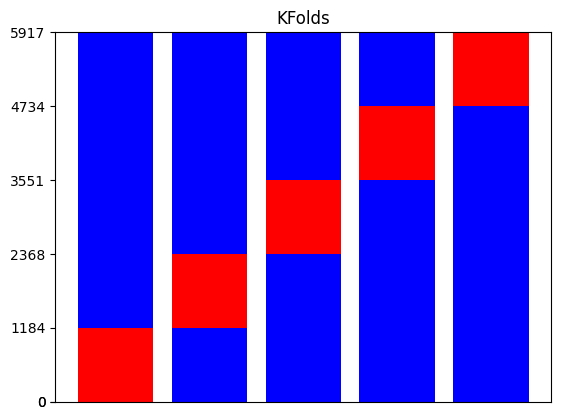

2024-05-31 15:18:23.560577


In [13]:
fig, ax = plt.subplots()
yticks = [0, len(X)]


for i, (train_index, test_index) in enumerate(KFold(n_splits = 5).split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    print(f"  Train indexes: {train_index[0]:5d} -> {train_index[-1]:5d}")
    print(f"  Test indexes:  {test_index[0]:5d} -> {test_index[-1]:5d}\n")
    
    maxval = max(test_index[-1], train_index[-1])
    
    ax.bar(i, maxval, color='blue', label='Training Set')
    
    ax.bar(i, test_index[-1]-test_index[0], bottom=test_index[0], color='red', label='Test Set')
    ax.set_ylim(0, maxval)
    
    yticks.append(test_index[0])
   

plt.title(f'KFolds')
plt.xticks([])
plt.yticks(yticks)
plt.show()

now()

def k_fold_cross_validation(model_json, X, y, num_folds, num_epochs, verbose=True):
    verbosity = 1 if verbose else 0
    show_plot = True if verbose else False

    folds = []
    histories = []
    
    for k, (training_index, test_index) in enumerate(KFold(n_splits = num_folds).split(X, y)):
        model = models.model_from_json(model_json)
        
        
        print(f'-> Fold {k+1}/{num_folds}')
        
        if verbose: print("  splitting...")
            
        # splitting
        X_train, X_test = X[training_index], X[test_index]
        y_train, y_test = y[training_index], y[test_index]
        
        if verbose: print("  training...")
        # training
        history = model.fit(
            X_train, 
            y_train, 
            validation_data = (X_test, y_test),
            epochs = num_epochs, 
            verbose = verbosity,
            shuffle='batch',
            callbacks = callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=10, 
                    restore_best_weights=True
                )
        )

        # scores
        evaluation = model.evaluate(X_test, y_test, return_dict=True)
        evaluation['fold_nr'] = k+1
        folds.append(evaluation)
        
        current_history = history.history
        current_history['fold_nr'] = k+1
        histories.append(current_history)
        
        if(show_plot):
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
            history_frame = pd.DataFrame(history.history)
            history_frame.loc[:, ['loss', 'val_loss']].plot(title='Losses', ax=axes[0])
            history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Binary accuracy", ax=axes[1])
            history_frame.loc[:, ['zero_one_loss', 'val_zero_one_loss']].plot(title="zero-one loss", ax=axes[2])
            plt.tight_layout(pad=2.0)
            plt.show()
    
    return folds, histories



#### MLP

2024-05-31 10:10:26.011727
-> Fold 1/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - binary_accuracy: 0.5021 - loss: 3.6477 - zero_one_loss: 0.4979 - val_binary_accuracy: 0.5904 - val_loss: 0.6627 - val_zero_one_loss: 0.4096
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.5607 - loss: 0.7110 - zero_one_loss: 0.4393 - val_binary_accuracy: 0.6647 - val_loss: 0.5878 - val_zero_one_loss: 0.3353
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.6246 - loss: 0.6496 - zero_one_loss: 0.3754 - val_binary_accuracy: 0.6554 - val_loss: 0.6073 - val_zero_one_loss: 0.3446
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.6921 - loss: 0.5888 - zero_one_loss: 0.3079 - val_binary_accuracy: 0.6816 - val_loss: 0.5786 - val_zero_one_loss: 0.3184
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7025 - loss: 0.5517 - zero_one_loss: 0.2975 - val_binary_accuracy: 0.752

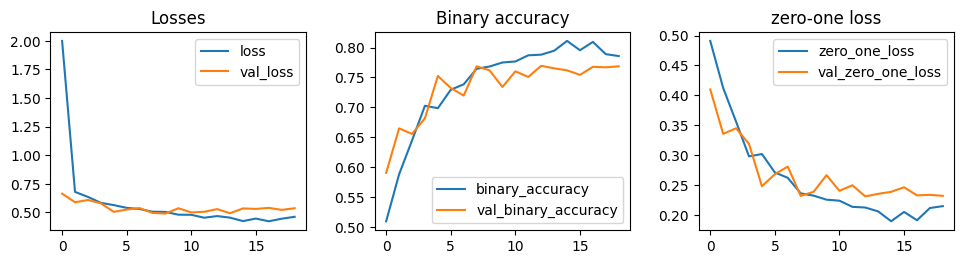

-> Fold 2/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - binary_accuracy: 0.5022 - loss: 3.1188 - zero_one_loss: 0.4978 - val_binary_accuracy: 0.6394 - val_loss: 0.6493 - val_zero_one_loss: 0.3606
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.5705 - loss: 0.7308 - zero_one_loss: 0.4295 - val_binary_accuracy: 0.6419 - val_loss: 0.6196 - val_zero_one_loss: 0.3581
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.6403 - loss: 0.6413 - zero_one_loss: 0.3597 - val_binary_accuracy: 0.6149 - val_loss: 0.6306 - val_zero_one_loss: 0.3851
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.6671 - loss: 0.6079 - zero_one_loss: 0.3329 - val_binary_accuracy: 0.6875 - val_loss: 0.6263 - val_zero_one_loss: 0.3125
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.6678 - loss: 0.6017 - zero_one_loss: 0.3322 - val_binary_accuracy: 0.6647 - val_loss: 0.5969 - val

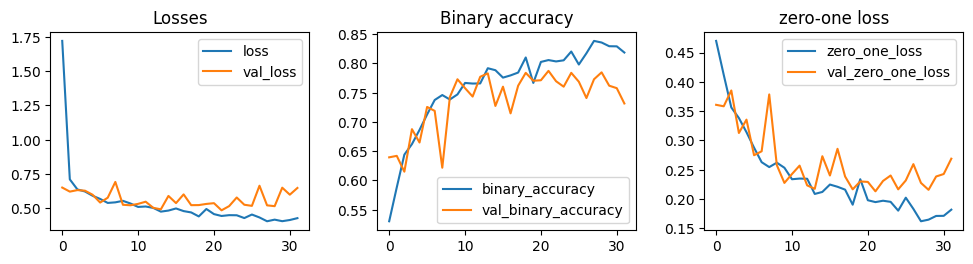

-> Fold 3/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - binary_accuracy: 0.5113 - loss: 2.6022 - zero_one_loss: 0.4887 - val_binary_accuracy: 0.6644 - val_loss: 0.6488 - val_zero_one_loss: 0.3355
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.5798 - loss: 0.7009 - zero_one_loss: 0.4202 - val_binary_accuracy: 0.6788 - val_loss: 0.5885 - val_zero_one_loss: 0.3212
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.6536 - loss: 0.6398 - zero_one_loss: 0.3464 - val_binary_accuracy: 0.6940 - val_loss: 0.5811 - val_zero_one_loss: 0.3059
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.6781 - loss: 0.6174 - zero_one_loss: 0.3219 - val_binary_accuracy: 0.7084 - val_loss: 0.5563 - val_zero_one_loss: 0.2916
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.6884 - loss: 0.5854 - zero_one_loss: 0.3116 - val_binary_accuracy: 0.6889 - val_loss: 0.6579 - val

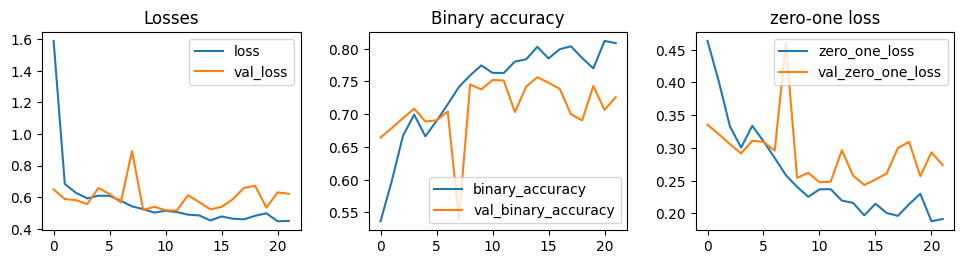

-> Fold 4/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - binary_accuracy: 0.5000 - loss: 3.8114 - zero_one_loss: 0.5000 - val_binary_accuracy: 0.6340 - val_loss: 0.6231 - val_zero_one_loss: 0.3659
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.5587 - loss: 0.7434 - zero_one_loss: 0.4413 - val_binary_accuracy: 0.6991 - val_loss: 0.6146 - val_zero_one_loss: 0.3008
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.6453 - loss: 0.6525 - zero_one_loss: 0.3547 - val_binary_accuracy: 0.6915 - val_loss: 0.5817 - val_zero_one_loss: 0.3084
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7062 - loss: 0.5763 - zero_one_loss: 0.2938 - val_binary_accuracy: 0.7236 - val_loss: 0.5579 - val_zero_one_loss: 0.2763
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.7169 - loss: 0.5631 - zero_one_loss: 0.2831 - val_binary_accuracy: 0.6923 - val_loss: 0.5695 - val

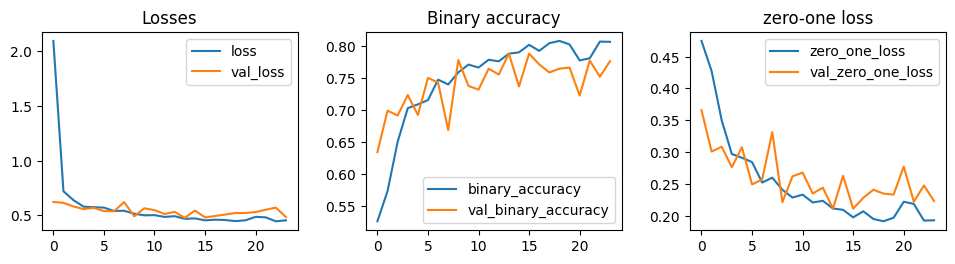

-> Fold 5/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - binary_accuracy: 0.5303 - loss: 3.9349 - zero_one_loss: 0.4697 - val_binary_accuracy: 0.4675 - val_loss: 0.7046 - val_zero_one_loss: 0.5324
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.5703 - loss: 0.7331 - zero_one_loss: 0.4297 - val_binary_accuracy: 0.7177 - val_loss: 0.5640 - val_zero_one_loss: 0.2824
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.6165 - loss: 0.6676 - zero_one_loss: 0.3835 - val_binary_accuracy: 0.6974 - val_loss: 0.5928 - val_zero_one_loss: 0.3027
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.6718 - loss: 0.6225 - zero_one_loss: 0.3282 - val_binary_accuracy: 0.7346 - val_loss: 0.5420 - val_zero_one_loss: 0.2655
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.6965 - loss: 0.5932 - zero_one_loss: 0.3035 - val_binary_accuracy: 0.7515 - val_loss: 0.5466 - val_

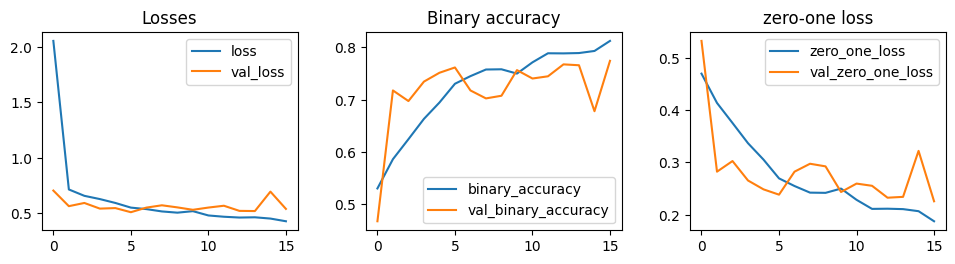

2024-05-31 10:13:48.122618
mlp:  [
 {
  "binary_accuracy": 0.7618243098258972,
  "loss": 0.4889039695262909,
  "zero_one_loss": 0.2381756752729416,
  "fold_nr": 1
 },
 {
  "binary_accuracy": 0.787162184715271,
  "loss": 0.48280003666877747,
  "zero_one_loss": 0.2128378450870514,
  "fold_nr": 2
 },
 {
  "binary_accuracy": 0.7514792680740356,
  "loss": 0.5155483484268188,
  "zero_one_loss": 0.24850152432918549,
  "fold_nr": 3
 },
 {
  "binary_accuracy": 0.7886728644371033,
  "loss": 0.47827431559562683,
  "zero_one_loss": 0.21123038232326508,
  "fold_nr": 4
 },
 {
  "binary_accuracy": 0.761622965335846,
  "loss": 0.5095245242118835,
  "zero_one_loss": 0.238393634557724,
  "fold_nr": 5
 }
] 



In [11]:
evaluations = {}
histories = {}

k = 'mlp'
now()
folds, history = k_fold_cross_validation(models_json[k], X, y, n_splits, 50, verbose = True)
evaluations[k] = folds
histories[k] = history
now()
for k in evaluations.keys():
    print(f"{k}: ",json.dumps(evaluations[k], indent=1), "\n")

#### CNN

2024-05-31 10:15:35.379386
-> Fold 1/5  --------
  splitting...
  training...
Epoch 1/50


2024-05-31 10:15:39.552126: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31758: 7.18885, expected 6.34915
2024-05-31 10:15:39.552179: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31794: 6.79032, expected 5.95062
2024-05-31 10:15:39.552188: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31795: 6.91364, expected 6.07395
2024-05-31 10:15:39.552196: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31796: 7.21123, expected 6.37153
2024-05-31 10:15:39.552203: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31809: 7.14567, expected 6.30597
2024-05-31 10:15:39.552212: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31823: 7.30269, expected 6.46299
2024-05-31 10:15:39.552220: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31824: 7.17199, expected 6.33229
2024-05-31 10:15:39.552228:

146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.6134 - loss: 2.9345 - zero_one_loss: 0.3866

2024-05-31 10:15:44.055313: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 216: 4.75113, expected 4.12849
2024-05-31 10:15:44.055373: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 576: 5.0232, expected 4.40056
2024-05-31 10:15:44.055384: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 707: 4.37677, expected 3.75413
2024-05-31 10:15:44.055393: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 914: 5.20101, expected 4.57836
2024-05-31 10:15:44.055402: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1125: 5.13819, expected 4.51554
2024-05-31 10:15:44.055410: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1189: 5.15223, expected 4.52959
2024-05-31 10:15:44.055417: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1238: 5.18909, expected 4.56645
2024-05-31 10:15:44.055426: E external/

148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - binary_accuracy: 0.6144 - loss: 2.8991 - zero_one_loss: 0.3856 - val_binary_accuracy: 0.6664 - val_loss: 0.6556 - val_zero_one_loss: 0.3336
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.7703 - loss: 0.5009 - zero_one_loss: 0.2297 - val_binary_accuracy: 0.7770 - val_loss: 0.5013 - val_zero_one_loss: 0.2230
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.8015 - loss: 0.4823 - zero_one_loss: 0.1985 - val_binary_accuracy: 0.6765 - val_loss: 0.7462 - val_zero_one_loss: 0.3235
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8255 - loss: 0.4084 - zero_one_loss: 0.1745 - val_binary_accuracy: 0.8378 - val_loss: 0.3971 - val_zero_one_loss: 0.1622
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.8284 - loss: 0.3955 - zero_one_loss: 0.1716 - val_binary_accuracy: 0.8024 - val_loss: 0.4396 - val_zero_one_loss: 0.1976
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━

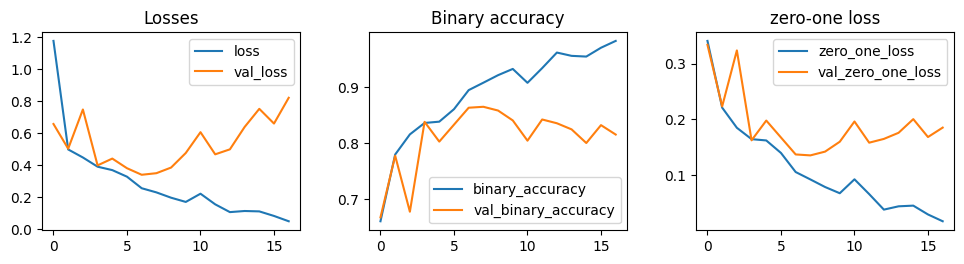

-> Fold 2/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - binary_accuracy: 0.6142 - loss: 2.1611 - zero_one_loss: 0.3858 - val_binary_accuracy: 0.7044 - val_loss: 0.7403 - val_zero_one_loss: 0.2956
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.7958 - loss: 0.4982 - zero_one_loss: 0.2042 - val_binary_accuracy: 0.8176 - val_loss: 0.4530 - val_zero_one_loss: 0.1824
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8226 - loss: 0.4325 - zero_one_loss: 0.1774 - val_binary_accuracy: 0.8285 - val_loss: 0.3826 - val_zero_one_loss: 0.1715
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8492 - loss: 0.3619 - zero_one_loss: 0.1508 - val_binary_accuracy: 0.8404 - val_loss: 0.3519 - val_zero_one_loss: 0.1596
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8664 - loss: 0.3100 - zero_one_loss: 0.1336 - val_binary_accuracy: 0.8556 - val_loss: 0.3471 - 

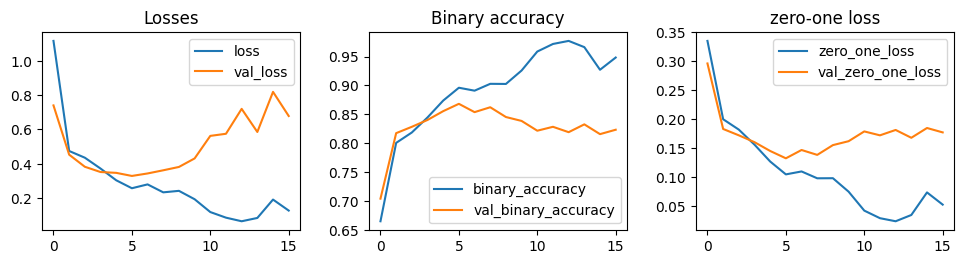

-> Fold 3/5  --------
  splitting...
  training...
Epoch 1/50
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.6560 - loss: 1.7797 - zero_one_loss: 0.3440

2024-05-31 10:17:04.627496: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47631: 7.35615, expected 6.48968
2024-05-31 10:17:04.627556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47632: 6.655, expected 5.78852
2024-05-31 10:17:04.627566: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47633: 7.19442, expected 6.32794
2024-05-31 10:17:04.627574: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47634: 7.37407, expected 6.50759
2024-05-31 10:17:04.627581: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47635: 6.61442, expected 5.74795
2024-05-31 10:17:04.627589: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47636: 6.43599, expected 5.56952
2024-05-31 10:17:04.627597: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47637: 7.15546, expected 6.28899
2024-05-31 10:17:04.627604: E

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - binary_accuracy: 0.6582 - loss: 1.7491 - zero_one_loss: 0.3418

2024-05-31 10:17:08.352792: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47806: 4.985, expected 4.36518
2024-05-31 10:17:08.352856: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48084: 4.83614, expected 4.21633
2024-05-31 10:17:08.352873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48178: 5.10975, expected 4.48993
2024-05-31 10:17:08.352896: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48219: 4.42858, expected 3.80877
2024-05-31 10:17:08.352910: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48335: 5.1248, expected 4.50498
2024-05-31 10:17:08.352922: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48451: 5.02718, expected 4.40737
2024-05-31 10:17:08.352935: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48815: 5.13136, expected 4.51155
2024-05-31 10:17:08.352946: E 

148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - binary_accuracy: 0.6586 - loss: 1.7432 - zero_one_loss: 0.3414 - val_binary_accuracy: 0.7861 - val_loss: 0.4873 - val_zero_one_loss: 0.2138
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8222 - loss: 0.4221 - zero_one_loss: 0.1778 - val_binary_accuracy: 0.8495 - val_loss: 0.3794 - val_zero_one_loss: 0.1504
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8460 - loss: 0.3742 - zero_one_loss: 0.1540 - val_binary_accuracy: 0.8470 - val_loss: 0.3585 - val_zero_one_loss: 0.1529
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8570 - loss: 0.3259 - zero_one_loss: 0.1430 - val_binary_accuracy: 0.8478 - val_loss: 0.3813 - val_zero_one_loss: 0.1521
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8866 - loss: 0.2591 - zero_one_loss: 0.1134 - val_binary_accuracy: 0.8597 - val_loss: 0.3488 - val_zero_one_loss: 0.1403
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━

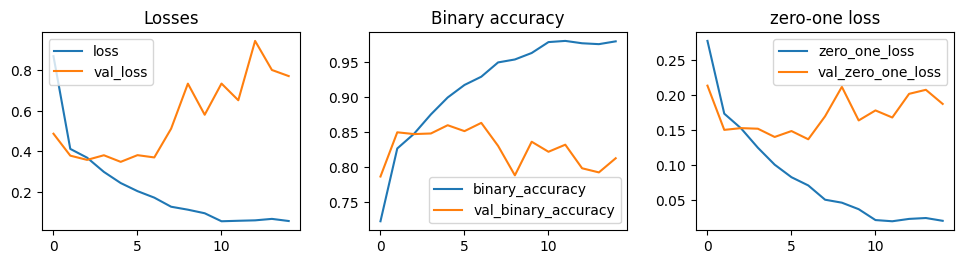

-> Fold 4/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - binary_accuracy: 0.6261 - loss: 4.7994 - zero_one_loss: 0.3739 - val_binary_accuracy: 0.7895 - val_loss: 0.4614 - val_zero_one_loss: 0.2104
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.7870 - loss: 0.5101 - zero_one_loss: 0.2130 - val_binary_accuracy: 0.8123 - val_loss: 0.4402 - val_zero_one_loss: 0.1877
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8087 - loss: 0.4758 - zero_one_loss: 0.1913 - val_binary_accuracy: 0.8402 - val_loss: 0.3983 - val_zero_one_loss: 0.1598
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8497 - loss: 0.3528 - zero_one_loss: 0.1503 - val_binary_accuracy: 0.7836 - val_loss: 0.5391 - val_zero_one_loss: 0.2164
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.8427 - loss: 0.3734 - zero_one_loss: 0.1573 - val_binary_accuracy: 0.8005 - val_loss: 0.5272 - 

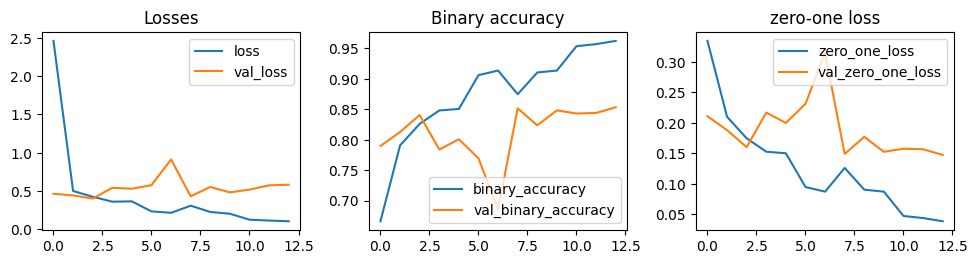

-> Fold 5/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - binary_accuracy: 0.6254 - loss: 4.7394 - zero_one_loss: 0.3746 - val_binary_accuracy: 0.7287 - val_loss: 1.6649 - val_zero_one_loss: 0.2714
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.7810 - loss: 1.1749 - zero_one_loss: 0.2190 - val_binary_accuracy: 0.6779 - val_loss: 2.6522 - val_zero_one_loss: 0.3222
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.7731 - loss: 1.5556 - zero_one_loss: 0.2269 - val_binary_accuracy: 0.7227 - val_loss: 1.9610 - val_zero_one_loss: 0.2772
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8415 - loss: 0.6814 - zero_one_loss: 0.1585 - val_binary_accuracy: 0.8199 - val_loss: 0.7034 - val_zero_one_loss: 0.1801
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.9190 - loss: 0.2386 - zero_one_loss: 0.0810 - val_binary_accuracy: 0.8098 - val_loss: 0.7291 - 

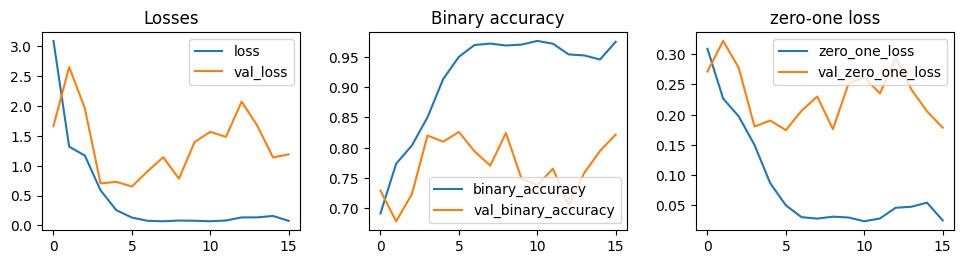

2024-05-31 10:18:47.985651
cnn:  [
 {
  "binary_accuracy": 0.8631756901741028,
  "loss": 0.338460773229599,
  "zero_one_loss": 0.1368243247270584,
  "fold_nr": 1
 },
 {
  "binary_accuracy": 0.8682432174682617,
  "loss": 0.3290727138519287,
  "zero_one_loss": 0.1317567527294159,
  "fold_nr": 2
 },
 {
  "binary_accuracy": 0.8596788048744202,
  "loss": 0.34884706139564514,
  "zero_one_loss": 0.14025719463825226,
  "fold_nr": 3
 },
 {
  "binary_accuracy": 0.8402366638183594,
  "loss": 0.39834722876548767,
  "zero_one_loss": 0.1597646027803421,
  "fold_nr": 4
 },
 {
  "binary_accuracy": 0.8258664608001709,
  "loss": 0.6515231132507324,
  "zero_one_loss": 0.17423169314861298,
  "fold_nr": 5
 }
] 



In [12]:
evaluations = {}
histories = {}

k = 'cnn'
now()
folds, history = k_fold_cross_validation(models_json[k], X, y, n_splits, 50, verbose = True)
evaluations[k] = folds
histories[k] = history
now()
for k in evaluations.keys():
    print(f"{k}: ",json.dumps(evaluations[k], indent=1), "\n")

#### Bigger CNN

2024-05-31 10:19:56.451796
-> Fold 1/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - binary_accuracy: 0.6085 - loss: 0.6311 - zero_one_loss: 0.3915 - val_binary_accuracy: 0.7948 - val_loss: 0.4711 - val_zero_one_loss: 0.2052
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7817 - loss: 0.4601 - zero_one_loss: 0.2183 - val_binary_accuracy: 0.8598 - val_loss: 0.3409 - val_zero_one_loss: 0.1402
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8170 - loss: 0.4186 - zero_one_loss: 0.1830 - val_binary_accuracy: 0.8615 - val_loss: 0.3267 - val_zero_one_loss: 0.1385
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8567 - loss: 0.3485 - zero_one_loss: 0.1433 - val_binary_accuracy: 0.8733 - val_loss: 0.3076 - val_zero_one_loss: 0.1267
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8662 - loss: 0.3253 - zero_one_loss: 0.1338 - val_binary_accuracy: 0.87

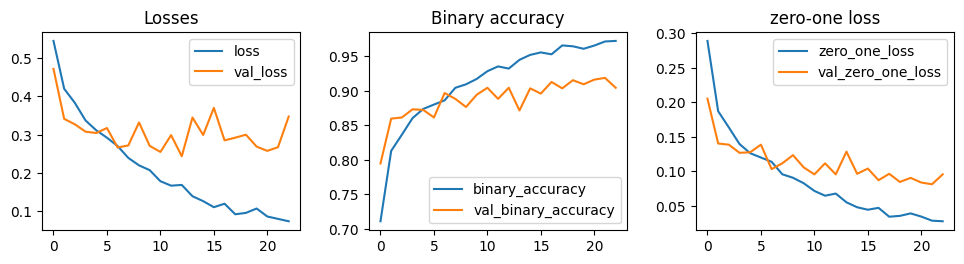

-> Fold 2/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - binary_accuracy: 0.6512 - loss: 0.6090 - zero_one_loss: 0.3488 - val_binary_accuracy: 0.8125 - val_loss: 0.4126 - val_zero_one_loss: 0.1875
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8102 - loss: 0.4279 - zero_one_loss: 0.1898 - val_binary_accuracy: 0.8438 - val_loss: 0.3728 - val_zero_one_loss: 0.1562
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8485 - loss: 0.3622 - zero_one_loss: 0.1515 - val_binary_accuracy: 0.8649 - val_loss: 0.3132 - val_zero_one_loss: 0.1351
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8722 - loss: 0.3202 - zero_one_loss: 0.1278 - val_binary_accuracy: 0.8725 - val_loss: 0.2910 - val_zero_one_loss: 0.1275
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8789 - loss: 0.3000 - zero_one_loss: 0.1211 - val_binary_accuracy: 0.8826 - val_loss: 0.2768 - val

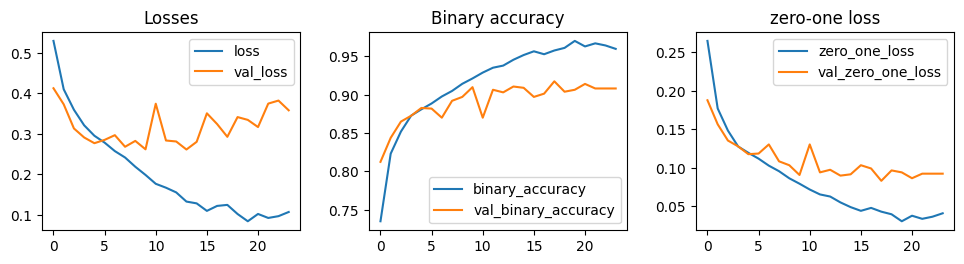

-> Fold 3/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - binary_accuracy: 0.6413 - loss: 0.6031 - zero_one_loss: 0.3587 - val_binary_accuracy: 0.8487 - val_loss: 0.3722 - val_zero_one_loss: 0.1512
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8213 - loss: 0.4090 - zero_one_loss: 0.1787 - val_binary_accuracy: 0.8529 - val_loss: 0.3614 - val_zero_one_loss: 0.1470
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8371 - loss: 0.3852 - zero_one_loss: 0.1629 - val_binary_accuracy: 0.8656 - val_loss: 0.3250 - val_zero_one_loss: 0.1344
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8628 - loss: 0.3250 - zero_one_loss: 0.1372 - val_binary_accuracy: 0.8749 - val_loss: 0.3043 - val_zero_one_loss: 0.1251
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.8706 - loss: 0.3064 - zero_one_loss: 0.1294 - val_binary_accuracy: 0.8690 - val_loss: 0.3282 - va

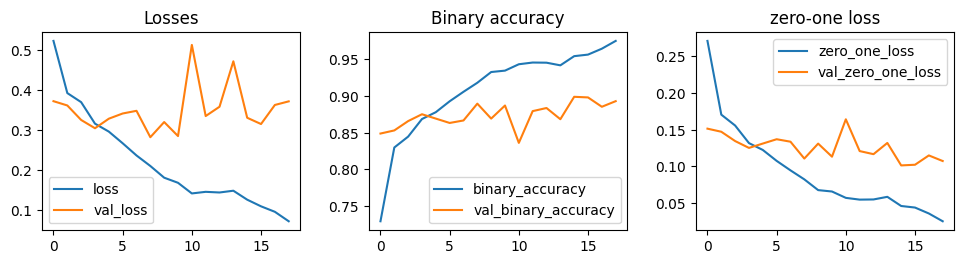

-> Fold 4/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - binary_accuracy: 0.6195 - loss: 0.6293 - zero_one_loss: 0.3805 - val_binary_accuracy: 0.7963 - val_loss: 0.4350 - val_zero_one_loss: 0.2038
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8116 - loss: 0.4232 - zero_one_loss: 0.1884 - val_binary_accuracy: 0.8478 - val_loss: 0.3828 - val_zero_one_loss: 0.1521
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8435 - loss: 0.3668 - zero_one_loss: 0.1565 - val_binary_accuracy: 0.8614 - val_loss: 0.3514 - val_zero_one_loss: 0.1386
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8609 - loss: 0.3288 - zero_one_loss: 0.1391 - val_binary_accuracy: 0.8774 - val_loss: 0.3384 - val_zero_one_loss: 0.1225
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8802 - loss: 0.2926 - zero_one_loss: 0.1198 - val_binary_accuracy: 0.8808 - val_loss: 0.3119 - val

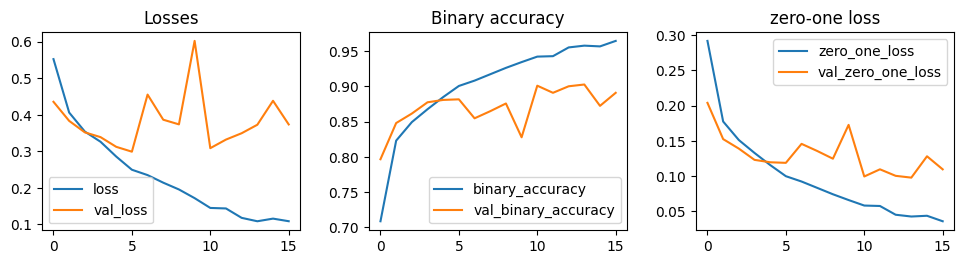

-> Fold 5/5  --------
  splitting...
  training...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - binary_accuracy: 0.6717 - loss: 0.5905 - zero_one_loss: 0.3283 - val_binary_accuracy: 0.7971 - val_loss: 0.4491 - val_zero_one_loss: 0.2028
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8473 - loss: 0.3692 - zero_one_loss: 0.1527 - val_binary_accuracy: 0.8800 - val_loss: 0.3026 - val_zero_one_loss: 0.1200
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8637 - loss: 0.3150 - zero_one_loss: 0.1363 - val_binary_accuracy: 0.8622 - val_loss: 0.3139 - val_zero_one_loss: 0.1378
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8806 - loss: 0.2956 - zero_one_loss: 0.1194 - val_binary_accuracy: 0.8648 - val_loss: 0.3428 - val_zero_one_loss: 0.1352
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.8887 - loss: 0.2786 - zero_one_loss: 0.1113 - val_binary_accuracy: 0.8825 - val_loss: 0.2919 - val

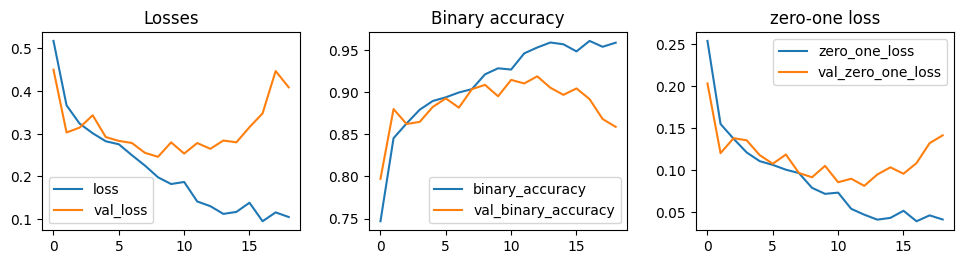

2024-05-31 10:23:28.820039
cnn1:  [
 {
  "binary_accuracy": 0.9045608043670654,
  "loss": 0.2435985803604126,
  "zero_one_loss": 0.09543918818235397,
  "fold_nr": 1
 },
 {
  "binary_accuracy": 0.9104729890823364,
  "loss": 0.26119473576545715,
  "zero_one_loss": 0.08952702581882477,
  "fold_nr": 2
 },
 {
  "binary_accuracy": 0.8892645835876465,
  "loss": 0.2817454934120178,
  "zero_one_loss": 0.11064188927412033,
  "fold_nr": 3
 },
 {
  "binary_accuracy": 0.88165682554245,
  "loss": 0.2985360026359558,
  "zero_one_loss": 0.11829773336648941,
  "fold_nr": 4
 },
 {
  "binary_accuracy": 0.9087066650390625,
  "loss": 0.24582195281982422,
  "zero_one_loss": 0.0913524404168129,
  "fold_nr": 5
 }
] 



In [13]:
evaluations = {}
histories = {}

k = 'cnn1'
now()
folds, history = k_fold_cross_validation(models_json[k], X, y, n_splits, 50, verbose = True)
evaluations[k] = folds
histories[k] = history
now()
for k in evaluations.keys():
    print(f"{k}: ",json.dumps(evaluations[k], indent=1), "\n")